In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy
import pandas as pd
import cmocean as cmo
from cartopy.util import add_cyclic_point
import seaborn as sns

In [2]:
# tarea = xr.open_dataset('/home/disk/atmos/vcooper/work/ref/' + 'cicefsdww3i.cice.h1.0086.nc').tarea
landfrac = xr.open_dataset('/home/disk/atmos/vcooper/work/ref/' + 'domain.lnd.fv1.9x2.5_gx1v6.090206.nc')

In [15]:
## load Annan data
path = '/home/disk/atmos/vcooper/work/p2c2/lgm/annan/'
annan_ens = xr.open_dataset(path + 'SST.all.lgm.nc').rename({'SST.all':'sst'})
annan_mean = xr.open_dataset(path + 'SST.mean.lgm.nc').rename({'SST.mean':'sst'})
annan_mean['longitude'] = np.sort(annan_mean.longitude)-180
annan_ens['longitude'] = annan_mean.longitude

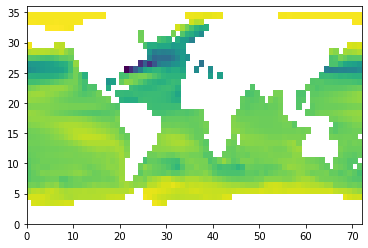

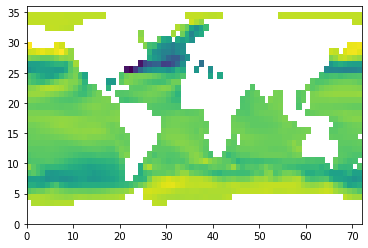

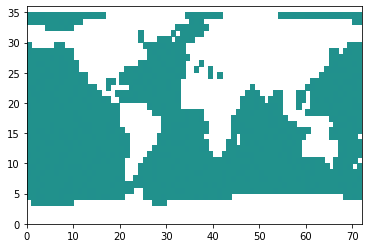

In [32]:
plt.pcolormesh(annan_mean.sst.values)
plt.show()

plt.pcolormesh(annan_ens.sst[0].values)
plt.show()

plt.pcolormesh(annan_ens.sst.mean(axis=0).values - annan_mean.sst.values,vmin=-0.001,vmax=0.001)
plt.show()

In [38]:
np.allclose(annan_ens.sst.mean(axis=0).values, annan_mean.sst.values,equal_nan=True)

True

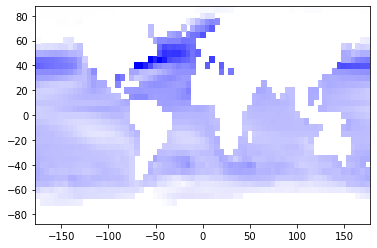

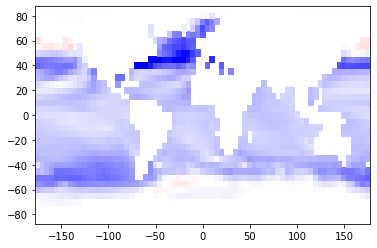

In [17]:
plt.pcolormesh(annan_mean.longitude, annan_mean.latitude, annan_mean.sst,cmap='bwr',vmin=-8,vmax=8)
plt.show()
plt.pcolormesh(annan_ens.longitude, annan_ens.latitude, annan_ens.sst[0],cmap='bwr',vmin=-8,vmax=8)
plt.show()

# plt.pcolormesh(annan_mean.longitude, annan_mean.latitude, annan_mean.sst,cmap='bwr',vmin=-8,vmax=8)
# plt.show()
# plt.pcolormesh(annan_ens.longitude, annan_ens.latitude, annan_ens.sst[0],cmap='bwr',vmin=-8,vmax=8)
# plt.show()

In [16]:
annan_mean.longitude

<xarray.DataArray 'longitude' (longitude: 72)>
array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,  47.5,
        52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,  92.5,  97.5,
       102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5, 137.5, 142.5, 147.5,
       152.5, 157.5, 162.5, 167.5, 172.5, 177.5, 182.5, 187.5, 192.5, 197.5,
       202.5, 207.5, 212.5, 217.5, 222.5, 227.5, 232.5, 237.5, 242.5, 247.5,
       252.5, 257.5, 262.5, 267.5, 272.5, 277.5, 282.5, 287.5, 292.5, 297.5,
       302.5, 307.5, 312.5, 317.5, 322.5, 327.5, 332.5, 337.5, 342.5, 347.5,
       352.5, 357.5])
Coordinates:
  * longitude  (longitude) float64 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5

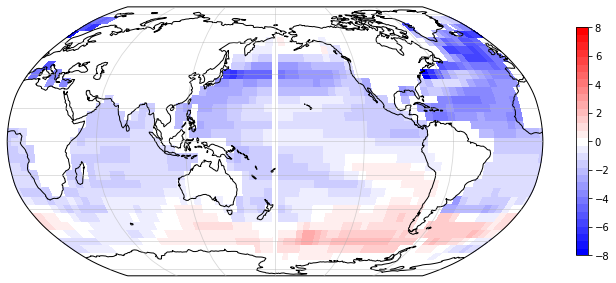

In [26]:
## checking the anomaly pattern before infill
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_ens.sst[1]
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(ds.lon, ds.lat, ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.pcolormesh(ds.longitude, ds.latitude, ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
# axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

## fix issue with lat lons by regridding

In [22]:
#############
### Preprocessing ###
## Load SST

ddir = '/home/disk/atmos/vcooper/work/p2c2/lgm/'
dfile = 'lgmDA_hol_SST_monthly_climo_v2.1.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = tempds.set_coords(['lat','lon','month'])
# tempds = xr.merge([tempds.set_coords(['lat','lon','month','ens']).sst,
#                    tempds.set_coords(['lat','lon','month','ens']).ens])
holo_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
holo_sst_climo['mask'] = xr.where(~np.isnan(holo_sst_climo.sst.isel(nmonth=0)), 1, 0)

# dfile = 'lgmDA_lgm_SST_monthly_climo.nc'
# ncf = ddir + dfile
# tempds = xr.open_dataset(ncf)
# tempds = tempds.set_coords(['lat','lon','month'])
# lgm_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
# lgm_sst_climo['mask'] = xr.where(~np.isnan(lgm_sst_climo.sst.isel(nmonth=0)), 1, 0)

# ## Load ICEFRAC
dfile = 'lgmDA_hol_ICEFRAC_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf).set_coords(['lat','lon','month'])
holo_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
holo_ice_climo['mask'] = xr.where(~np.isnan(holo_ice_climo.icefrac.isel(nmonth=0)), 1, 0)

dfile = 'lgmDA_lgm_ICEFRAC_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf).set_coords(['lat','lon','month'])
lgm_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
lgm_ice_climo['mask'] = xr.where(~np.isnan(lgm_ice_climo.icefrac.isel(nmonth=0)), 1, 0)

In [28]:
################
# xesmf regridding 
newgrid = holo_ice_climo # desired grid
data_for_regridding = lgm_sst_climo

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',
#                          filename='bilinear_margo_to_holo_per_extrapID.nc',
                         reuse_weights=False)
lgm_sst_climo_hologrid_extrap = regridder(lgm_sst_climo)

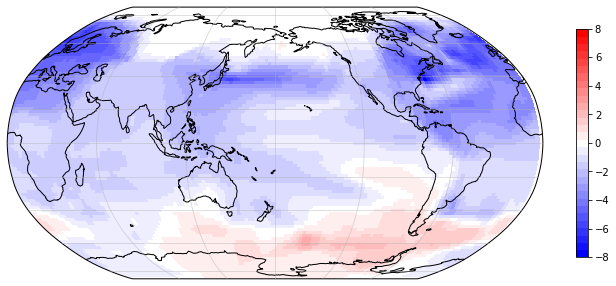

In [29]:
## checking the anomaly pattern before infill
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = lgm_sst_climo_hologrid_extrap.sst[1]
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(ds.lon, ds.lat, ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.pcolormesh(ds.lon, ds.lat, ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
# axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()